In [2]:
from datetime import timedelta

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colorbar import cm
import numpy as np
from tqdm.notebook import tqdm

In [3]:
trivago = pd.read_pickle('../data/minimal_distances/trivago.pickle.bz2')
spotify = pd.read_pickle('../data/minimal_distances/spotify.pickle.bz2')
microsoft = pd.read_pickle('../data/minimal_distances/microsoft.pickle.bz2')

In [4]:
all_minimal_distances = {
    'Trivago': trivago,
    'Spotify': spotify,
    'Microsoft': microsoft
}

In [5]:
def compute_ranges(minimal_distances, name, normalize):
    c = minimal_distances.groupby(level=0).shortest.count()
    if normalize:
        num_participants = minimal_distances.index.get_level_values(0).categories.size
        c = (c/num_participants).round(decimals=2)
    cc = c.value_counts(normalize=True).sort_index()
    index = None
    if normalize:
        index = np.arange(0, cc.index.max()+0.001, step=0.01)
        s = cc.reindex(index, fill_value=0, tolerance=0.001, method='nearest')
    else:
        index = np.arange(0, cc.index.max()+1, step=1, dtype=np.int64)
        s = cc.reindex(index, fill_value=0)
    s.index.rename('range', inplace=True)
    return s.sort_index().cumsum().rename(name)

# Normalized Information Diffusion Ranges

In [6]:
normalized_ranges = pd.concat([compute_ranges(minimal_distances, name, True) for name, minimal_distances in all_minimal_distances.items()], axis=1).sort_index()

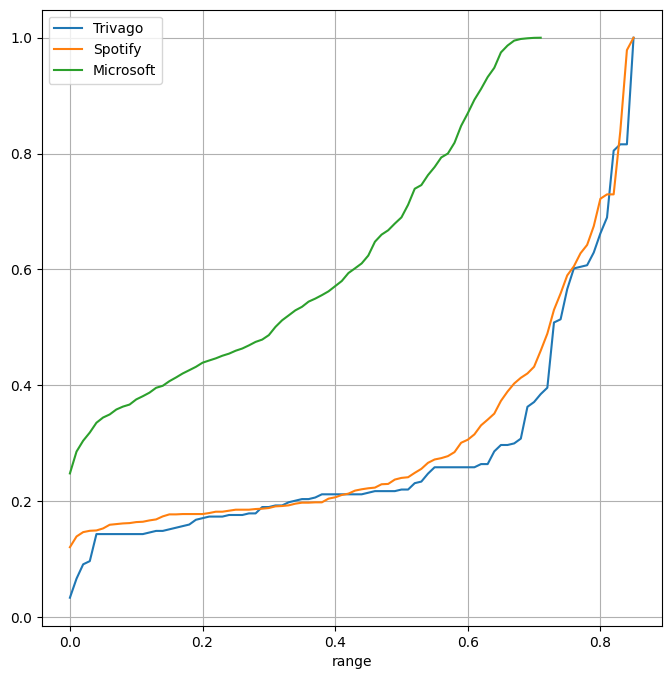

In [7]:
fig, ax = plt.subplots(figsize=(8,8), dpi=100)
normalized_ranges.plot(ax=ax)

plt.grid('both')

In [8]:
normalized_ranges.to_csv(f'../reports/csv/ranges.csv', index_label='index', float_format='%g')

In [9]:
l = []
m = normalized_ranges.idxmax().rename('max')
for i in [0.3, 0.5, 0.7, 0.9]:
    name = f'\\num{{{(1-i):.2f}}}'
    l += [pd.Series({i: f'\\numrange{{{v:.2f}}}{{{m[i]}}}' for i, v in normalized_ranges[normalized_ranges<=i].idxmax().rename(name).round(decimals=2).to_dict().items()}, name=name)]
l += ['\\num{' + normalized_ranges.idxmax().rename('max').astype(str) + '}']
df = pd.concat(l, axis=1)

with open('../reports/tex/normalized_ranges.tex', 'w') as file:
    df.to_latex(file, float_format='.2f')

df

,\num{0.70},\num{0.50},\num{0.30},\num{0.10},max
Trivago,\numrange{0.67}{0.85},\numrange{0.72}{0.85},\numrange{0.81}{0.85},\numrange{0.83}{0.85},\num{0.85}
Spotify,\numrange{0.58}{0.85},\numrange{0.72}{0.85},\numrange{0.79}{0.85},\numrange{0.83}{0.85},\num{0.85}
Microsoft,\numrange{0.01}{0.71},\numrange{0.30}{0.71},\numrange{0.50}{0.71},\numrange{0.61}{0.71},\num{0.71}


# Information Diffusion Ranges

In [10]:
ranges = pd.concat([compute_ranges(minimal_distances, name, False) for name, minimal_distances in all_minimal_distances.items()], axis=1).sort_index()

In [11]:
l = []
m = ranges.idxmax().rename('max')
for i in [0.3, 0.5, 0.7, 0.9]:
    name = f'\\num{{{(1-i):.2f}}}'
    l += [pd.Series({i: f'\\numrange{{{v}}}{{{m[i]}}}' for i, v in ranges[ranges<=i].idxmax().rename(name).round(decimals=2).to_dict().items()}, name=name)]
l += ['\\num{' + ranges.idxmax().rename('max').astype(str) + '}']
df = pd.concat(l, axis=1)

with open('../reports/tex/ranges.tex', 'w') as file:
    df.to_latex(file)

df

,\num{0.70},\num{0.50},\num{0.30},\num{0.10},max
Trivago,\numrange{245}{310},\numrange{266}{310},\numrange{296}{310},\numrange{309}{310},\num{310}
Spotify,\numrange{1026}{1472},\numrange{1260}{1472},\numrange{1386}{1472},\numrange{1447}{1472},\num{1472}
Microsoft,\numrange{808}{26216},\numrange{11645}{26216},\numrange{18887}{26216},\numrange{22983}{26216},\num{26216}


# Ranges over time

In [12]:
def compute_range_over_time(df):
    result = []
    total = len(df.index.get_level_values(0).categories)
    for source, group in tqdm(df.fastest.groupby(level=0), total=total):
        n_unique = group.reset_index(level=1).resample(pd.Timedelta(days=1), on='fastest', offset=-group.min()).target.nunique()
        result += [n_unique.rename(source)]
    index = pd.timedelta_range(start=timedelta(weeks=0), end=timedelta(weeks=4), freq='D')
    return pd.concat(result, axis=1).fillna(0).cumsum().reindex(index).ffill().astype(int)

In [13]:
ranges_over_time = {
    'Trivago': compute_range_over_time(trivago),
    'Spotify': compute_range_over_time(spotify),
    'Microsoft': compute_range_over_time(microsoft),    
}

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/1730 [00:00<?, ?it/s]

  0%|          | 0/37103 [00:00<?, ?it/s]

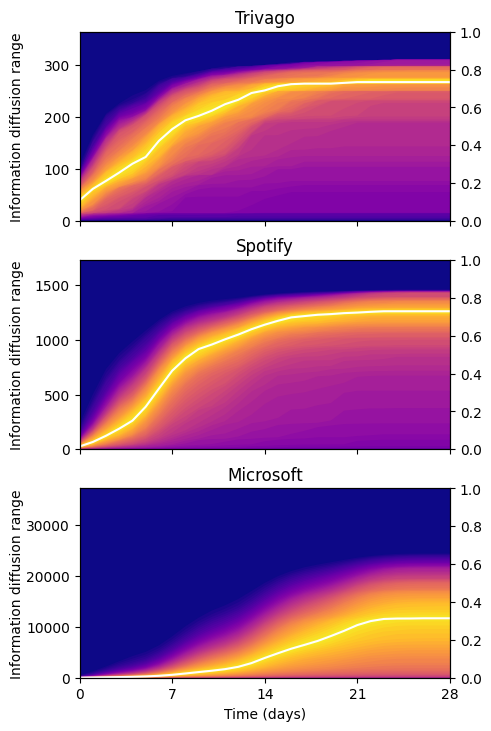

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(4.8,1.5*4.8), constrained_layout=True, sharex=True, sharey=False)

for i, (name, range_ecdf) in enumerate(ranges_over_time.items()):
    ax = axes[i]
    #x_labels = ecdf.index
    df = range_ecdf.reset_index(drop=True)
    x = df.index
    
    norm = cm.colors.Normalize(vmin=0.0, vmax=50)
    q = np.column_stack((np.linspace(0.99, 0.51, 49), np.linspace(0.01, 0.49, 49)))
    ax.fill_between(x=x, y1=0, y2=1, color=cm.plasma(norm(0)), edgecolor=None)
    for c, (l,u) in enumerate(q):
        y1 = df.quantile(l, axis=1).rename(l)
        y2 = df.quantile(u, axis=1).rename(u)
        color = cm.plasma(norm(c))
        for_cbar = ax.fill_between(x=x, y1=y1, y2=y2, color=color, edgecolor=None)
    

    df.median(axis=1).plot(ax=ax, color='white')

    ax.set_xlim(0, df.index.max())
    ax.set_ylim((0, df.shape[1]))
    ax.set_facecolor(cm.plasma(norm(0)))

    ax.set_ylabel('Information diffusion range')
    
    ax.set_xticks([0, 7, 14, 21, 28])
    ax.set_xticklabels([0, 7, 14, 21, 28])
    ax.minorticks_off()
    ax.set_title(name)

    ax_m = ax.twinx()   # mirror the x-axis
    ax_m.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);
    #ax_m.set_ylabel('Normalized information diffusion range')
    ax.set_xlabel('Time (days)')

    ax.yaxis.set_label_coords(-0.15, 0.5)
    # ax.axhline(df.shape[1]/2)


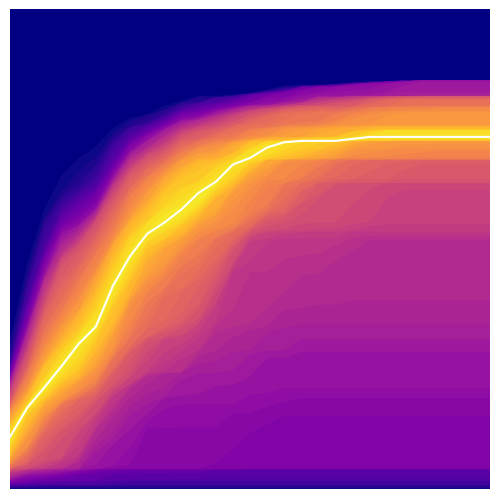

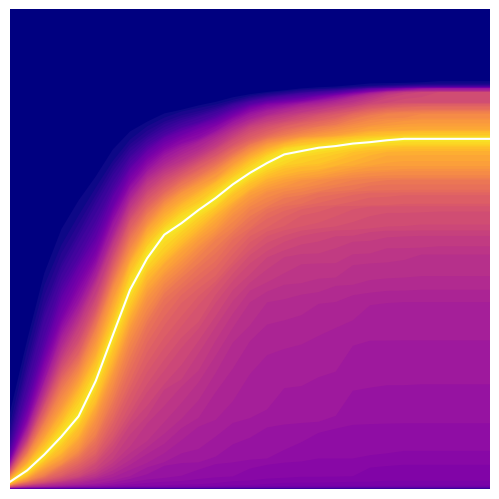

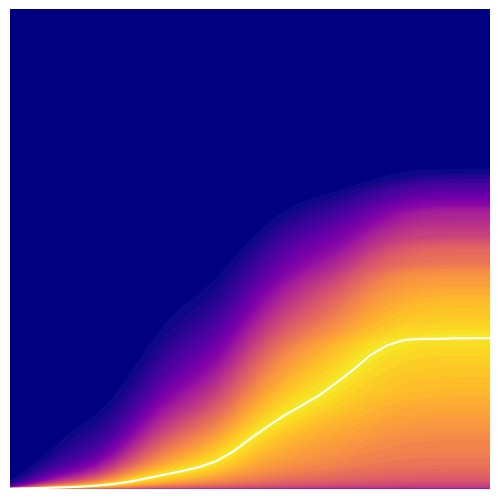

In [17]:
for i, (name, range_ecdf) in enumerate(ranges_over_time.items()):
    fig, ax = plt.subplots(figsize=(4.8,4.8), dpi=100)

    df = range_ecdf.reset_index(drop=True)
    x = df.index
    
    norm = cm.colors.Normalize(vmin=0.0, vmax=50)
    q = np.column_stack((np.linspace(0.99, 0.51, 49), np.linspace(0.01, 0.49, 49)))
    ax.fill_between(x=x, y1=0, y2=1, color=cm.plasma(norm(0)), edgecolor=None)
    for c, (l,u) in enumerate(q):
        y1 = df.quantile(l, axis=1).rename(l)
        y2 = df.quantile(u, axis=1).rename(u)
        color = cm.plasma(norm(c))
        for_cbar = ax.fill_between(x=x, y1=y1, y2=y2, color=color, edgecolor=None)

    df.median(axis=1).plot(ax=ax, color='white')

    ax.set_xlim(0, df.index.max())
    ax.set_ylim((0, df.shape[1]))
    ax.set_facecolor(cm.jet(norm(0)))
    plt.subplots_adjust(bottom = 0, top = 1, left = 0, right = 1, hspace = 0, wspace = 0)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    fig.savefig(f'../reports/png/range_over_time_{name.lower()}.png', format='png')

Text(0, 0.5, 'Inter-percentile range')

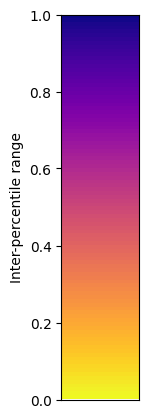

In [ ]:
fig, ax = plt.subplots(figsize=(1, 5))
y = np.linspace(0,1, num=100)
x = y

ax.imshow(np.transpose(x[np.newaxis,:]), cmap="plasma", aspect="auto", extent=(0, 1, 0, 1))
ax.set_xticks([])
ax.set_ylim(0, 1)
ax.set_ylabel('Inter-percentile range')